In [1]:
import subprocess as sp
import sys
from tqdm.notebook import tqdm
import parmed as pmd
from rdkit.Chem import AllChem as Chem
from openff.toolkit.topology import Molecule
from openff.toolkit.utils.toolkits import (
    ToolkitRegistry,
    RDKitToolkitWrapper,
    BuiltInToolkitWrapper,
    AmberToolsToolkitWrapper,
)
import openmm.unit as unit
from openmm.app import PDBFile

In [2]:
toolkit_precedence = [
    RDKitToolkitWrapper,
    AmberToolsToolkitWrapper,
    BuiltInToolkitWrapper,
]
toolkit_registry = ToolkitRegistry(toolkit_precedence)
toolkit_registry

ToolkitRegistry containing The RDKit, AmberTools, Built-in Toolkit

In [3]:
def getAtomMapNumber(atm):
    if "molAtomMapNumber" in atm.GetPropNames():
        i = int(atm.GetProp("molAtomMapNumber"))
    else:
        i = -1
    return i

In [4]:
def getAtomMapNumber(atm):
    if "molAtomMapNumber" in atm.GetPropNames():
        i = int(atm.GetProp("molAtomMapNumber"))
    else:
        i = -1
    return i

In [5]:
class mol2_reader(object):
    def __init__(self, Path):

        self.path = Path

        self.N_atoms = 0

        self.atomid = list()
        self.atomname = list()
        self.crds = list()
        self.types = list()
        self.resid = list()
        self.resname = list()
        self.charges = list()

        self.__infile = None

        self.__read()

    def __read(self):

        found_start = False
        self.__infile = open(self.path, "r")

        for l in self.__infile:
            line = l.rstrip().split()
            if len(line) == 0:
                continue
            if not found_start and line[0] == "@<TRIPOS>ATOM":
                found_start = True
                continue
            if line[0] in ["@<TRIPOS>BOND", "@<TRIPOS>UNITY_ATOM_ATTR"]:
                break
            if found_start:
                self.atomid.append(int(line[0]))
                self.atomname.append(str(line[1]))
                self.crds.append([float(line[2]), float(line[3]), float(line[4])])
                self.types.append(str(line[5]))
                self.resid.append(int(line[6]))
                self.resname.append(str(line[7]))
                self.charges.append(float(line[8]))

        self.N_atoms = len(self.atomid)

    def write(self, path):

        found_start = False
        found_end = False

        self.__infile.seek(0)

        with open(path, "w") as outfile:
            for l in self.__infile:
                line = l.rstrip().split()
                if len(line) > 0 and line[0] in [
                    "@<TRIPOS>BOND",
                    "@<TRIPOS>UNITY_ATOM_ATTR",
                ]:
                    found_end = True
                if found_start and not found_end:
                    continue
                if len(line) > 0 and not found_start and line[0] == "@<TRIPOS>ATOM":
                    outfile.write("@<TRIPOS>ATOM")
                    outfile.write("\n")
                    for i in range(self.N_atoms):
                        outfile.write("%7d" % self.atomid[i])
                        outfile.write("%2s          " % self.atomname[i])
                        outfile.write("%7.4f   " % self.crds[i][0])
                        outfile.write("%7.4f   " % self.crds[i][1])
                        outfile.write("%7.4f " % self.crds[i][2])
                        outfile.write("%-5s   " % self.types[i])
                        outfile.write("%d  " % self.resid[i])
                        outfile.write("%s       " % self.resname[i])
                        outfile.write("%7.4f" % self.charges[i])
                        outfile.write("\n")

                    found_start = True
                    continue

                outfile.write(l)

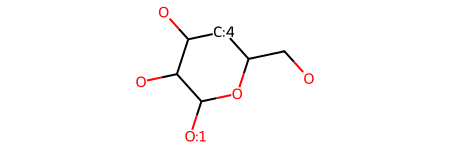

In [6]:
build_folder = "build_files"
input_file = f"{build_folder}/bcd.mol2"
output_file = f"{build_folder}/bcd.am1bcc.sybyl.mol2"
fragments_smarts = "[#6]1(-[#8:1])-[#6](-[#8])-[#6](-[#8])-[#6$([#6]):4]-[#6](-[#6]-[#8])-[#8]-1"
query_mol = Chem.MolFromSmarts(fragments_smarts)
query_mol

In [7]:
# --------------------------------------------------------------#
# Load files
# --------------------------------------------------------------#
input_mol = Chem.MolFromMol2File(input_file, removeHs=False)
query_mol = Chem.MolFromSmarts(fragments_smarts)

# --------------------------------------------------------------#
# Get bond list
# --------------------------------------------------------------#
input_matches = input_mol.GetSubstructMatches(query_mol)
bond_list = list()
dummy_labels = list()
for match in input_matches:
    for query_idx, atm_idx in enumerate(match):
        if getAtomMapNumber(query_mol.GetAtomWithIdx(query_idx)) != 1:
            continue
        atm = input_mol.GetAtomWithIdx(atm_idx)
        for nghbr_atm in atm.GetNeighbors():
            if not nghbr_atm.GetIdx() in match:
                bond = input_mol.GetBondBetweenAtoms(atm_idx, nghbr_atm.GetIdx())
                bond_idx = bond.GetIdx()
                if bond_idx in bond_list:
                    continue
                bond_list.append(bond_idx)
                if bond.GetBeginAtomIdx() == atm_idx:
                    dummy_labels.append([1, 4])
                else:
                    dummy_labels.append([4, 1])

# --------------------------------------------------------------#
# Get smiles of fragment
# --------------------------------------------------------------#
mol_list = list()
mol_atm_idxs_list = list()
input_mol_frags = Chem.FragmentOnBonds(
    input_mol, bond_list, dummyLabels=dummy_labels
)
flist = list()
for fragmol, fragmol_atm_idxs in zip(
    Chem.GetMolFrags(input_mol_frags, asMols=True),
    Chem.GetMolFrags(input_mol_frags, asMols=False),
):
    flist.append(fragmol)
    atm_idx_list = list()
    rwmol = Chem.RWMol(fragmol)
    for atm, atm_idx in zip(fragmol.GetAtoms(), fragmol_atm_idxs):
        ### This is where the labels are stored
        label = atm.GetIsotope()
        if label == 1:
            rwmol.ReplaceAtom(atm.GetIdx(), Chem.Atom(8))
            rwmol.AddAtom(Chem.Atom(6))
            rwmol.AddBond(
                atm.GetIdx(),
                fragmol.GetNumAtoms(),
                order=Chem.rdchem.BondType.SINGLE,
            )
            fragmol = rwmol.GetMol()
        elif label == 4:
            rwmol.ReplaceAtom(atm.GetIdx(), Chem.Atom(6))
        else:
            atm_idx_list.append(atm_idx)
    fragmol = rwmol.GetMol()
    Chem.SanitizeMol(fragmol)
    fragmol.Compute2DCoords()
    mol_list.append(fragmol)
    mol_atm_idxs_list.append(atm_idx_list)

smi_list = [Chem.CanonSmiles(Chem.MolToSmiles(mol)) for mol in mol_list]
unique_smi = list(set(smi_list))
unique_idx = [smi_list.index(smi) for smi in smi_list]

# --------------------------------------------------------------#
# Charging process
# --------------------------------------------------------------#
off_list = dict()
charges_list = dict()
for frag_idx in list(set(unique_idx)):
    # Add Hydrogens and Generate Conformer
    mol = Chem.AddHs(mol_list[frag_idx])
    Chem.EmbedMultipleConfs(mol)
    Chem.MMFFOptimizeMoleculeConfs(mol)

    # Write SDF file for fragment
    writer = Chem.SDWriter(f"./frag{frag_idx}.sdf")
    writer.write(mol, confId=1)
    writer.close()

    # Use OBabel to convert SDF to MOL2
    output = sp.Popen(
        [
            "obabel",
            "-isdf",
            f"./frag{frag_idx}.sdf",
            "-omol2",
            "-O",
            f"./frag{frag_idx}.mol2",
        ],
        stdout=sp.PIPE,
        stderr=sp.PIPE,
        cwd="./",
    )

    # Use OFF to assign AM1BCC with Antechamber Backend
    mol_off = Molecule.from_file(f"./frag{frag_idx}.sdf")
    mol_off.assign_partial_charges("am1bcc")
    off_list[frag_idx] = mol_off
    charges_list[frag_idx] = mol_off.partial_charges.value_in_unit(
        unit.elementary_charge
    )

# --------------------------------------------------------------#
# Generate dictionary of Charges
# --------------------------------------------------------------#
charge_props_dict = dict()
total_charge = 0.0
for mol_idx, frag_idx in enumerate(unique_idx):
    mol_atm_idxs = mol_atm_idxs_list[mol_idx]
    mol = mol_list[mol_idx]
    #         mol_q_H = mol_off.to_rdkit()
    self_match = off_list[frag_idx].to_rdkit().GetSubstructMatch(mol)
    for fragmol_atm_idx, mol_atm_idx in enumerate(mol_atm_idxs):
        charge = charges_list[frag_idx][self_match[fragmol_atm_idx]]
        #             atm_CD = input_mol.GetAtomWithIdx(mol_atm_idx)
        #             atm_frag = mol_q_H.GetAtomWithIdx(self_match[fragmol_atm_idx])
        charge_props_dict[mol_atm_idx] = charge
        total_charge += charge

# --------------------------------------------------------------#
# Distribute charge error
# --------------------------------------------------------------#
diff = total_charge - float(Chem.GetFormalCharge(input_mol))
diff_add = diff / float(len(charge_props_dict))
charge_props_list = list()
for atm_idx in range(input_mol.GetNumAtoms()):
    if atm_idx not in charge_props_dict:
        print(atm_idx)
        continue
    charge = charge_props_dict[atm_idx] - diff_add
    charge_props_list.append(str(charge))
input_mol.SetProp("Partial_charges", "\n".join(charge_props_list))

# --------------------------------------------------------------#
# Save files
# --------------------------------------------------------------#
# Create new MOL2 file with charges using ParmEd
structure = pmd.load_file(input_file, structure=True)
for atom, charge in zip(structure.atoms, charge_props_list):
    atom.charge = float(charge)
structure.save(output_file, overwrite=True)

# Create new SDF file with charges using OFF-toolkit
off_q = Molecule.from_rdkit(input_mol)
off_q.to_file(output_file.replace(".mol2", ".sdf"), file_format="SDF")

# Create new PDB file with openmm.app
with open(output_file.replace(".mol2", ".pdb"), "w") as f:
    PDBFile.writeFile(
        structure.topology,
        structure.positions,
        f,
        keepIds=True,
    )